# Basic setup

In [8]:
# loading python packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import os
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from natsort import natsorted, ns
import glob
from pymer4.models import Lmer
%load_ext rpy2.ipython

fpath = 'where/you/have/the/data'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
%%R 
# loading R packages
library('lme4')
library('lmerTest')
library('lsmeans')

# Doctor - Conditioning - Overall pain rating

In [10]:
doc_data = pd.read_csv(os.path.join(fpath,'study1_doc_condition_rating_data.csv'))
doc_mean = doc_data.groupby(['DyadID','Condition'])['Pain_Rating'].mean().reset_index()

## Figure 1(A-3)

[Text(0, 0, 'Control'), Text(1, 0, 'Thermedol')]

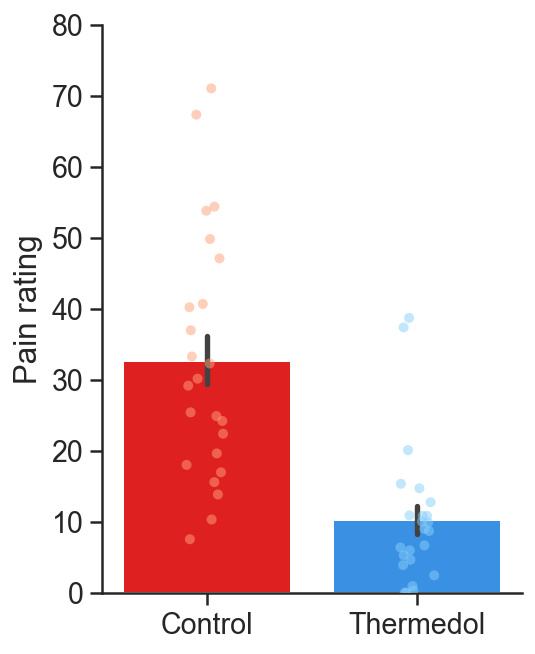

In [14]:
sns.set(style="ticks", font_scale=1.3)
g = sns.catplot(x="Condition", y="Pain_Rating", palette={'Thermedol':'dodgerblue','Vaseline':'red'},units='DyadID',
                   n_boot=5000, ci=68, data=doc_mean, kind="bar", order=['Vaseline','Thermedol'], aspect=.8)
g = sns.stripplot(x="Condition", y="Pain_Rating", palette={'Thermedol':'lightskyblue','Vaseline':'lightsalmon'},
                   data=doc_mean, order=['Vaseline','Thermedol'],alpha=.5)

g.set(ylim=(0, 80))
plt.ylabel('Pain rating')
plt.xlabel('')
g.set_xticklabels(["Control","Thermedol"])

In [19]:
doc_data['trials_c'] = doc_data.Trials - doc_data.Trials.mean()

In [27]:
%%R -i doc_data
doc_data$Site <- factor(doc_data$Site)
doc_data$Color <- factor(doc_data$Current_color)
doc_data$Condition <- factor(doc_data$Condition_new)

doc_overall_m <- lmer(Pain_Rating ~ Site + trials_c + Color + Condition + 
                         (1 + trials_c + Condition| DyadID), data = doc_data)

summary(doc_overall_m)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Pain_Rating ~ Site + trials_c + Color + Condition + (1 + trials_c +  
    Condition | DyadID)
   Data: doc_data

REML criterion at convergence: 1486.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8209 -0.3606 -0.0738  0.4112  3.1404 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 DyadID   (Intercept) 280.33   16.743              
          trials_c     12.99    3.604    0.08      
          Condition1  157.73   12.559   -0.84  0.18
 Residual              88.81    9.424              
Number of obs: 192, groups:  DyadID, 24

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  32.3771     4.0936  35.8800   7.909 2.24e-09 ***
Site2         0.4862     1.9798 128.1900   0.246   0.8064    
Site3        -1.7985     2.7239  37.8000  -0.660   0.5131    
Site4        -1.1443     2.7246  37.8400  -0.420   

# Doctor - Conditioning - Belief of Effectiveness

In [29]:
doc_q = pd.read_csv(os.path.join(fpath,'study1_doc_condition_belief_data.csv'))

In [32]:
doc_q_pre = doc_q[doc_q['Time']==0].reset_index(drop=True)
doc_q_post = doc_q[doc_q['Time']==1]

effect_diff = doc_q_post['Effectiveness'].values - doc_q_pre['Effectiveness'].values
effect_diff = pd.DataFrame(effect_diff, columns = ['Effective_change'])

effect_diff['DyadID'] = doc_q_pre['DyadID']

effect_diff['Condition'] = 'Thermedol'

## Figure. 1(A-2, left panel)

/Users/PinhaoChen/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


[Text(0, 0, 'Thermedol')]

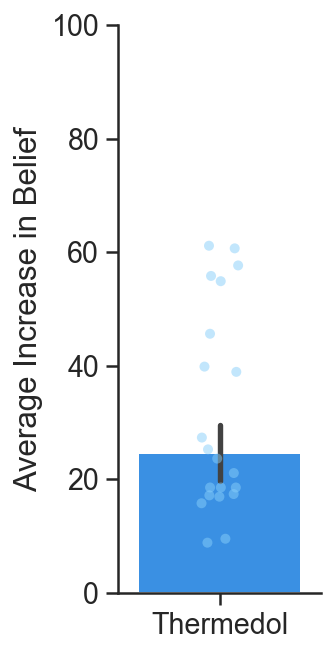

In [69]:
sns.set(style="ticks", font_scale=1.3)
g = sns.factorplot(x="Condition", y="Effective_change", palette={'Thermedol':'dodgerblue'},units='DyadID',
                   n_boot=5000, ci=68, data=effect_diff, kind="bar", aspect=.5)

g = sns.stripplot(x="Condition", y="Effective_change", 
    palette={'Thermedol':'lightskyblue'},
    data=effect_diff,alpha=.5)

g.set(ylim=(0, 100))
plt.ylabel('Average Increase in Belief')
plt.xlabel('')

g.set_xticklabels(["Thermedol"])

In [35]:
%%R -i doc_q
doc_q$Time <- factor(doc_q$Time)
effectivness_model <- lmer(Effectiveness ~ Time + (1 | DyadID), data = doc_q)
summary(effectivness_model)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Effectiveness ~ Time + (1 | DyadID)
   Data: doc_q

REML criterion at convergence: 423.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2489 -0.4328  0.1064  0.6063  1.5772 

Random effects:
 Groups   Name        Variance Std.Dev.
 DyadID   (Intercept) 266.6    16.33   
 Residual             310.2    17.61   
Number of obs: 48, groups:  DyadID, 24

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   45.640      4.902 37.900   9.310 2.45e-11 ***
Time1         24.595      5.084 23.000   4.838 6.98e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      (Intr)
Time1 -0.519


## Figure. 1(A-2, right panel) - doctors' beliefs during interaction phase

In [73]:
doc_q_interact = pd.read_csv(os.path.join(fpath,'study1_doc_interaction_belief_data.csv'))

In [74]:
doc_q_interact_pre = doc_q_interact[doc_q_interact["Time"]==1]

[Text(0, 0, 'Control'), Text(1, 0, 'Thermedol')]

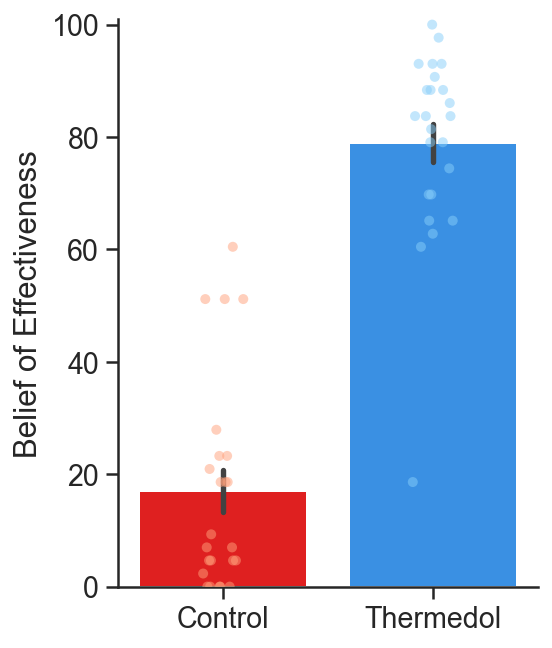

In [76]:
sns.set(style="ticks", font_scale=1.3)
g = sns.catplot(x="Condition", y="effectiveness", 
                palette={'Thermedol':'dodgerblue','Vaseline':'red'},units='DyadID',
                   n_boot=5000, ci=68, data=doc_q_interact_pre, kind="bar", 
                order=['Vaseline','Thermedol'], aspect=.8)

g = sns.stripplot(x="Condition", y="effectiveness", 
                  palette={'Thermedol':'lightskyblue','Vaseline':'lightsalmon'},
                   data=doc_q_interact_pre, order=['Vaseline','Thermedol'],alpha=.5)

g.set(ylim=(0, 101))
plt.ylabel('Belief of Effectiveness')
plt.xlabel('')
g.set_xticklabels(["Control","Thermedol"])

In [80]:
%%R -i doc_q_interact
doc_q_interact$Time <- factor(doc_q_interact$Time)
doc_q_interact$Condition_new <- factor(doc_q_interact$Condition_new)
doc_effectivness_model <- lmer(effectiveness ~ Time*Condition_new+ (1 + Time + Condition_new | DyadID), data = doc_q_interact)
summary(doc_effectivness_model)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: effectiveness ~ Time * Condition_new + (1 + Time + Condition_new |  
    DyadID)
   Data: doc_q_interact

REML criterion at convergence: 767.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.68121 -0.33624 -0.09631  0.39416  2.05466 

Random effects:
 Groups   Name           Variance Std.Dev. Corr       
 DyadID   (Intercept)    322.27   17.952              
          Time2           32.60    5.709    0.46      
          Condition_new1 644.91   25.395   -0.76 -0.32
 Residual                 54.16    7.359              
Number of obs: 96, groups:  DyadID, 24

Fixed effects:
                     Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)            17.054      3.960 24.710   4.306  0.00023 ***
Time2                   4.942      2.423 43.660   2.039  0.04749 *  
Condition_new1         61.919      5.602 26.540  11.053 1.97e-11 ***
Time2:C